🚀 Step 1: Environment Setup
Before we start coding, make sure you have the necessary libraries installed. We'll be using:

Pandas: For data manipulation.
NumPy: For numerical operations.
Scikit-learn: For preprocessing, model building, and evaluation.
NLTK/Spacy: For text preprocessing (tokenization, stopword removal).
Matplotlib/Seaborn: For data visualization (optional).

In [1]:
pip install pandas numpy scikit-learn nltk seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


📥 Step 2: Import Libraries

In [16]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization (Optional but helpful)
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing
import re  # For regular expressions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier


🚩 Step 3: Load the Dataset

In [5]:
# Load the datasets
train_data = pd.read_csv('train/train.csv',encoding='utf-8')
test_data = pd.read_csv('test/test.csv',encoding='utf-8')

# Check the first few rows
print(train_data.head())
print(test_data.head())


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  ==

🚀 Step 4: Data Exploration (EDA - Exploratory Data Analysis)
We'll inspect the data to understand its structure.

✅ 1. Check Basic Information

In [6]:
# Check the first few rows
print(train_data.head())

# Check for missing values and data types
print(train_data.info())

# Check for null values
print(train_data.isnull().sum())

# Check basic statistics (optional)
print(train_data.describe())


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------

In [8]:
# Checking the distribution of all target labels
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(train_data[label_columns].sum())


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


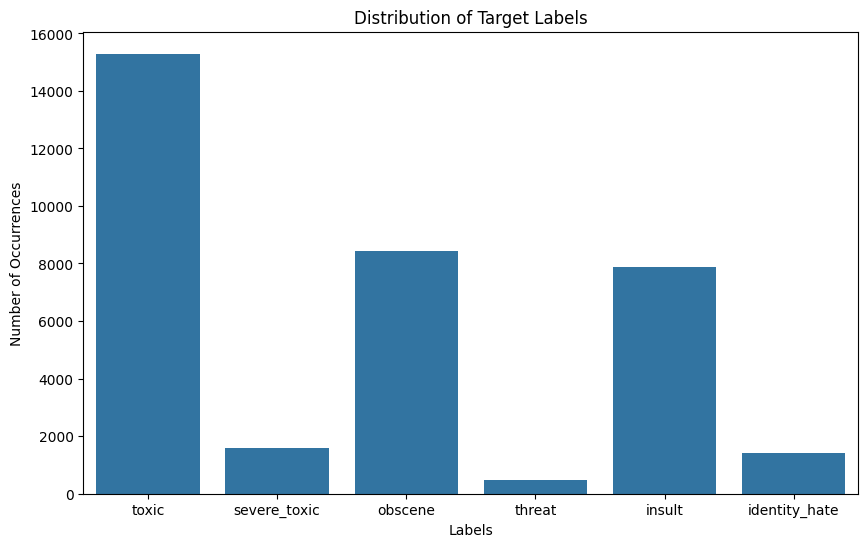

In [9]:
# Plotting the distribution of target labels
plt.figure(figsize=(10, 6))
sns.barplot(x=train_data[label_columns].sum().index, y=train_data[label_columns].sum().values)
plt.title('Distribution of Target Labels')
plt.xlabel('Labels')
plt.ylabel('Number of Occurrences')
plt.show()

In [10]:
# Function to clean the text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

# Apply the cleaning function to the comment_text column
train_data['clean_comment'] = train_data['comment_text'].apply(clean_text)


In [11]:
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the stopword removal function
train_data['clean_comment'] = train_data['clean_comment'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # Using unigrams & bigrams
X = tfidf.fit_transform(train_data['clean_comment'])

# Target Labels
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Logistic Regression with One-vs-Rest strategy
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [18]:
# Predicting on validation data
y_pred = model.predict(X_val)

# Evaluation for each label
for idx, label in enumerate(y_train.columns):
    print(f"Classification Report for {label}:")
    print(classification_report(y_val.iloc[:, idx], y_pred[:, idx]))
    print("-" * 50)

Classification Report for toxic:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.90      0.61      0.73      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915

--------------------------------------------------
Classification Report for severe_toxic:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31594
           1       0.57      0.21      0.31       321

    accuracy                           0.99     31915
   macro avg       0.78      0.61      0.65     31915
weighted avg       0.99      0.99      0.99     31915

--------------------------------------------------
Classification Report for obscene:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30200
           1       0.91    

In [19]:
# Clean the test comments
test_data['clean_comment'] = test_data['comment_text'].apply(clean_text)
test_data['clean_comment'] = test_data['clean_comment'].apply(remove_stopwords)

# Transform using the same TF-IDF vectorizer
X_test = tfidf.transform(test_data['clean_comment'])

# Predict on the test data
test_predictions = model.predict(X_test)

# Prepare submission
submission = pd.DataFrame(test_predictions, columns=y_train.columns)
submission['id'] = test_data['id']

# Save predictions to CSV
submission.to_csv('submission.csv', index=False)